In [1]:
# import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing


In [2]:
df_ori = pd.read_csv('diabetic_data.csv')
df = df_ori.copy(deep=True)
#for x in df.columns:
#    print(x, df[x].unique())

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
print(df.shape)
print(df.dtypes)
class_counts = df.groupby('readmitted').size() 
print(class_counts)



(101766, 50)
encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepi

In [5]:
# # pd.set_option('display.width', 100)
# # pd.set_option('precision', 3)
# # correlations = df.corr(method='pearson')
# # print(correlations) 
# dfcopy = df_ori.copy(deep=True)
numerics = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id',
           'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
           'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient',
            'number_diagnoses']

others = [col for col in df.columns if col not in numerics]

scaler = MinMaxScaler()
x_num = scaler.fit_transform(df[numerics])
x_all = np.concatenate([x_num, df[others].values], axis =1)

df_copy = pd.DataFrame(data=x_all, columns=numerics+others)

print(df_copy['race'])
# print("SKEWS")
# skew = df.skew()
# #print(df.head())
# print(skew) 
# print(df['number_diagnoses'])

# #using minmax scaler does not take away skew

# from sklearn.preprocessing import minmax_scale

# for x in numerics:
#     dfcopy[x] = minmax_scale(dfcopy[x])
# print("SKEWS -- minmax")    
# skew = dfcopy.skew()
# print(skew) 
# print(dfcopy['number_diagnoses'])
# # print(df['number_diagnoses'])
# # from sklearn.preprocessing import Normalizer
# # X = dfcopy[numerics].values
# # for x in numerics:
# #     scaler = Normalizer().fit()
# #     normalizedX = scaler.transform([dfcopy[x]])
# # #     #print(normalizedX
# # #     print(dfcopy[x].size, normalizedX.size)
# # #     print(dfcopy[x])
# # #     dfcopy[x] = normalizedX

# # def standardize(raw_data):
# #     return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))
# # dfcopy[numerics] = standardize(dfcopy[numerics])

# # print("SKEWS---Normalized")
# # print(dfcopy['number_diagnoses'])
# # skew = dfcopy.skew()
# # #print(df.head())
# # print(skew) 

0               Caucasian
1               Caucasian
2         AfricanAmerican
3               Caucasian
4               Caucasian
               ...       
101761    AfricanAmerican
101762    AfricanAmerican
101763          Caucasian
101764          Caucasian
101765          Caucasian
Name: race, Length: 101766, dtype: object


In [6]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1) #should we code it into 1 and 2?
df['readmitted'] = df['readmitted'].replace('NO', 0)
df.readmitted.value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

In [7]:
df.drop(columns = ['patient_nbr','citoglipton','weight','examide','encounter_id', 'medical_specialty', 'payer_code'],inplace=True)
#df.drop(columns = ['citoglipton','weight','examide','encounter_id', 'medical_specialty', 'payer_code'],inplace=True)

#df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
drop_Idx = set()
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1']=='?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2']=='?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3']=='?'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,Steady,No,No,No,No,No,No,Yes,0


In [8]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 
        'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 
        'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)
    
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)

df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)

df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

df['age'] = df['age'].replace('[0-10)', 5)
df['age'] = df['age'].replace('[10-20)', 15)
df['age'] = df['age'].replace('[20-30)', 25)
df['age'] = df['age'].replace('[30-40)', 35)
df['age'] = df['age'].replace('[40-50)', 45)
df['age'] = df['age'].replace('[50-60)', 55)
df['age'] = df['age'].replace('[60-70)', 65)
df['age'] = df['age'].replace('[70-80)', 75)
df['age'] = df['age'].replace('[80-90)', 85)
df['age'] = df['age'].replace('[90-100)', 95)

df['race'] = df['race'].replace('Caucasian', 0)
df['race'] = df['race'].replace('AfricanAmerican', 1)
df['race'] = df['race'].replace('Hispanic', 2)
df['race'] = df['race'].replace('Asian', 3)
df['race'] = df['race'].replace('Other', 4)

df = df.replace('?', -1)
#df.head()

for col in df:
    print(col, " : ")
    print(df[col].unique())
    

race  : 
[ 0  1 -1  4  3  2]
gender  : 
[0 1]
age  : 
[15 25 35 45 55 65 75 85 95  5]
admission_type_id  : 
[1 2 3 6 4 5 8 7]
discharge_disposition_id  : 
[ 1  3  6  2  5  7 25 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28 19
 27]
admission_source_id  : 
[ 7  2  4  1  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital  : 
[ 3  2  1  4  5 13 12  9  7 10  6 11  8 14]
num_lab_procedures  : 
[ 59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29  35
  42  66  36  19  64  25  53  52  87  27  37  41  28  48  10   2  65  67
  40  54  58  57  43  32  83  34  39  69  38  72  22  96  46  78  56  61
  88  50   1  18  82   9  63  24  71  77  81  76  90  93   3 103  13  80
  85  16  15  12  30  23  17  21  79  26   5  95  97  84  14  74 105  86
  98  20   6  94   8 102   7  89  91  92   4 101  99 100 114 113 111 129
 107 108 106 104 109 120 132 121 126 118]
num_procedures  : 
[0 5 1 6 2 3 4]
num_medications  : 
[18 13 16  8 21 12 28 17 11 15 31  2 23 19  7 20 14 10 22  9 25  4 

In [9]:
# df.loc[(df.diag_1.str.contains('V')),'diag_1']=0
# df.loc[(df.diag_1.str.contains('E')),'diag_1']=0

# df.loc[(df.diag_2.str.contains('V')),'diag_2']=0
# df.loc[(df.diag_2.str.contains('E')),'diag_2']=0

# df.loc[(df.diag_3.str.contains('V')),'diag_3']=0
# df.loc[(df.diag_3.str.contains('E')),'diag_3']=0

# for i in df['diag_1']:
#     b = 'V' in str(i)
#     c = 'E' in str(i)
#     if b or c:
#         print(str(i))
        
        
# for i in df['diag_2']:
#     b = 'V' in str(i)
#     c = 'E' in str(i)
#     if b or c:
#         print(str(i))
        
        
# for i in df['diag_3']:
#     b = 'V' in str(i)
#     c = 'E' in str(i)
#     if b or c:
#         print(str(i))

diags = ['diag_1','diag_2','diag_3']
    
def detection(value):
    if value[0]== "V" or value[0] == 'E':
        value = '0'
        return value # from new york united healthcare
    else:
        return value
    
for f in diags:
    for i in df[f].index:
        df[f].at[i] = detection(df[f].at[i])
        
for i in df['diag_1']:
    b = 'V' in str(i)
    c = 'E' in str(i)
    if b or c:
        print(str(i))
        
#print(df['diag_1'].unique())
        
#print(df['diag_2'].unique())
        
#print(df['diag_3'].unique())


    

In [10]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
#print("geelo ", df.columns)
df.drop(['number_outpatient', 'number_emergency', 'number_inpatient'], axis=1, inplace=True)
df.dtypes

race                         int64
gender                       int64
age                          int64
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                    int64
repaglinide                  int64
nateglinide                  int64
chlorpropamide               int64
glimepiride                  int64
acetohexamide                int64
glipizide                    int64
glyburide                    int64
tolbutamide                  int64
pioglitazone                 int64
rosiglitazone                int64
acarbose                     int64
miglitol            

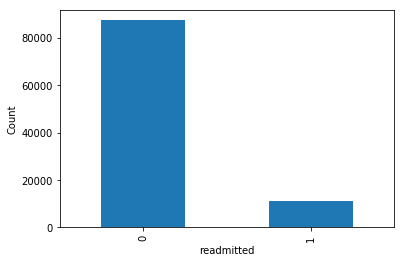

(98601, 95)


In [11]:
#df_age = pd.get_dummies(df['age'])
#df_race = pd.get_dummies(df['race'])
#df_gender = pd.get_dummies(df['gender'])
#df_change = pd.get_dummies(df['change'])
#df_diabetesMed = pd.get_dummies(df['diabetesMed'])

df_max_glu_serum = pd.get_dummies(df['max_glu_serum'])
df_A1Cresult = pd.get_dummies(df['A1Cresult'])
df_insulin = pd.get_dummies(df['insulin'])
df_discharge_disposition_id = pd.get_dummies(df['discharge_disposition_id'])
df_admission_source_id = pd.get_dummies(df['admission_source_id'])
df_admission_type_id = pd.get_dummies(df['admission_type_id'])

#print(df_max_glu_serum)
#df = pd.concat([df,df_max_glu_serum])
#df.drop(['max_glu_serum'], axis=1, inplace=True)             
df = pd.concat([df,df_max_glu_serum, df_A1Cresult, 
                df_insulin, df_discharge_disposition_id, 
                df_admission_source_id, df_admission_type_id], axis=1)
df.drop([ 'max_glu_serum', 'A1Cresult', 'insulin','discharge_disposition_id', 'admission_source_id', 
                  'admission_type_id'], axis=1, inplace=True)
#before
df.groupby('readmitted').size().plot(kind='bar')
plt.ylabel('Count')
plt.show()

print(df.shape)
# df = df['readmitted' == 1 or 'readmitted' == 0]
#df.readmitted = np.where(df.readmitted=2, 0, df.readmitted)
#after
# df.groupby('readmitted').size().plot(kind='bar')
# plt.ylabel('Count')
# plt.title("AFTER CHANGE")
# plt.show()
# #print(df.iloc[0])
# #df.head()
# df.head()

In [12]:
#from sklearn
#scaler = MinMaxScaler().fit(df)
#normalizedDF = scaler.transform(df)

#pd.DataFrame(data=normalizedDF, columns=df.columns)

In [13]:
from sklearn.model_selection import train_test_split

feature_col_names = df.columns
#print(df.columns)
#x = df[feature_col_names]
#x = x.drop('readmitted', axis=1)
x = df.loc[:, df.columns != 'readmitted']
y = df['readmitted']
#print(x.columns, y)
#print(y.unique())
#print(x, y)
print(x.iloc[0])
print(y.iloc[0])
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20, random_state=1)

race                   0
gender                 0
age                   15
time_in_hospital       3
num_lab_procedures    59
                      ..
4                      0
5                      0
6                      0
7                      0
8                      0
Name: 1, Length: 94, dtype: object
0


In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(x.values, y)
print('New dataset shape {}'.format(Counter(train_output_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(x.columns))
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

# print(X_dev)
# print(Y_dev)

Original dataset shape Counter({0: 87351, 1: 11250})
New dataset shape Counter({0: 87351, 1: 87351})


## Voting Ensemble (with 10-fold cross validation)

### Voting Ensemble #1: Dtree, Random Forest, NN  (all with default parameters)

In [15]:
# Voting Ensemble for Classification
import pandas
from sklearn import model_selection
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm

kfold = model_selection.KFold(n_splits=10)

# create the sub models
estimators = []
model1 = tree.DecisionTreeClassifier()
estimators.append(('DecisionTree', model1))
model2 = RandomForestClassifier()
estimators.append(('RandomForest', model2))
model3 = MLPClassifier()
estimators.append(('NN', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results1 = model_selection.cross_val_score(ensemble, x, y, cv=kfold)
print(results1.mean())

0.8854575413665776


In [16]:
print("accuracy: ", results1.mean())

accuracy:  0.8854575413665776


### Voting Ensemble #2: Dtree, Random Forest, NN

In [17]:
# Voting Ensemble for Classification
import pandas
from sklearn import model_selection
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm

kfold = model_selection.KFold(n_splits=10)

# create the sub models
estimators = []
model1 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth= 100 )
estimators.append(('DecisionTree', model1))
model2 = RandomForestClassifier(random_state=0, n_estimators = 110)
estimators.append(('RandomForest', model2))
model3 = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
estimators.append(('NN', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results2 = model_selection.cross_val_score(ensemble, x, y, cv=kfold)
print(results2.mean())

0.8860153506972063


In [18]:
print('accuracy: ', results2.mean())

accuracy:  0.8860153506972063


## Ada Boost (with 10-fold cross validation)

In [19]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100)
ADAscores = cross_val_score(clf, x, y, cv=10)

In [20]:
print('accuracy: ', ADAscores.mean())

accuracy:  0.8855792493345123


## Gradient Boosting (with 10-fold cross validation)

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
GBscores = cross_val_score(clf, x, y, cv=10)

In [22]:
print('accuracy: ', GBscores.mean())

accuracy:  0.8859342199370438


In [28]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(X_train, Y_train)
preds = clf.predict(X_test)
print("ACCURACY " , accuracy_score(Y_test, preds))


preds = clf.predict(X_train)
print("train ACCURACY " , accuracy_score(Y_train, preds))

ACCURACY  0.8829673951625171
train ACCURACY  0.9315116520345447


## Random Forest: (with 10-fold cross validation)

In [23]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=0, n_estimators = 110)
clf.fit(X_train, Y_train)
preds = clf.predict(X_test)
RFscores = cross_val_score(clf, x, y, cv=10)
RFscores.mean()

0.8860457818031696

In [24]:
print('accuracy: ', RFscores.mean())

accuracy:  0.8860457818031696


## Algorithm Comparison 

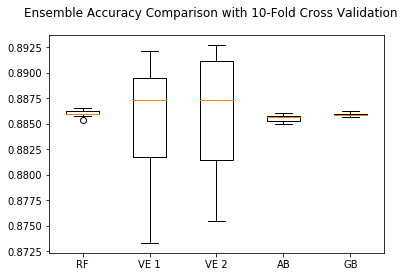

In [25]:
import matplotlib.pyplot as plt

results = [RFscores, results1, results2, ADAscores ,GBscores]
names = ['RF', 'VE 1', 'VE 2', 'AB', 'GB'  ]

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Ensemble Accuracy Comparison with 10-Fold Cross Validation')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

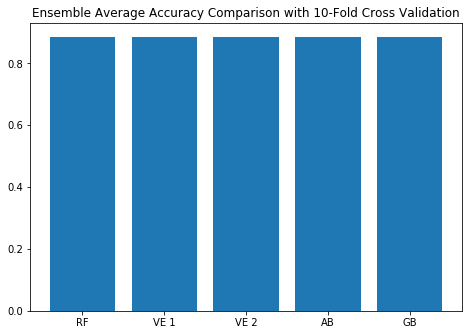

[0.8860457818031696, 0.8854575413665776, 0.8860153506972063, 0.8855792493345123, 0.8859342199370438]


In [26]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
results = [RFscores.mean(), results1.mean(), results2.mean(), ADAscores.mean() ,GBscores.mean()]
names = ['RF', 'VE 1', 'VE 2', 'AB', 'GB'  ]
ax.bar(names,results)
plt.title('Ensemble Average Accuracy Comparison with 10-Fold Cross Validation')
plt.show()
print(results)